# Machine Learning Model

## Objective

The objective of this machine learning analysis is to examine whether patterns of AI assistant usage can be used to predict students’ academic performance. Building upon the exploratory data analysis and hypothesis testing conducted earlier, this notebook applies supervised machine learning models to assess the predictive relationship between AI usage intensity, usage intent, and academic outcomes.

The primary focus is not to establish causality, but to evaluate the extent to which AI usage variables contribute to explaining variation in academic performance.

## Install Libraries

In [188]:
%pip install pandas numpy matplotlib seaborn scikit-learn imblearn jupyter

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [189]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## Load Datasets & Data Cleaning

In [190]:
# Load the datasets
df = pd.read_csv("data/perf_ai.csv")
df['Department'] = df['Department'].replace({'EXTC': 'Engineering', 'IT' : 'Business', 'Comp': 'CS'})
df

,StudentID,Department,CGPA,ChatGPT_Usage_Frequency_Per_Week,Average_Session_Duration_Minutes,Reason_For_Using_ChatGPT,Aptitude_Score
0,1,Engineering,7.55,2,16,saves time,4
1,2,Business,7.23,17,119,saves time,1
2,3,Engineering,8.11,13,62,no idea,2
3,4,Engineering,6.65,17,18,better answers,0
4,5,Business,5.42,1,91,no idea,0
...,...,...,...,...,...,...,...
232,233,Engineering,7.93,9,57,saves time,6
233,234,CS,7.70,2,28,better answers,7
234,235,CS,8.15,1,44,saves time,7
235,236,CS,8.42,0,33,saves time,8


In [191]:
# If Duration exists, force Frequency to at least 1
mask1 = (df['ChatGPT_Usage_Frequency_Per_Week'] == 0) & (df['Average_Session_Duration_Minutes'] > 0)
df.loc[mask1, 'ChatGPT_Usage_Frequency_Per_Week'] = 1

# If Frequency exists, fill 0 Duration with the Median of non-zero durations
median_duration = df[df['Average_Session_Duration_Minutes'] > 0]['Average_Session_Duration_Minutes'].median()
print(median_duration)

mask2 = (df['ChatGPT_Usage_Frequency_Per_Week'] > 0) & (df['Average_Session_Duration_Minutes'] == 0)
df.loc[mask2, 'Average_Session_Duration_Minutes'] = median_duration

42.0


## Data Merging & Enrichment

In [ ]:
df['Total_AI_Time'] = df['ChatGPT_Usage_Frequency_Per_Week'] * df['Average_Session_Duration_Minutes']
df['Avg_CGPA_by_Dept'] = df.groupby('Department')['CGPA'].transform('mean')
df['Relative_CGPA'] = df['CGPA'] - df['Avg_CGPA_by_Dept']
df['Aptitude_x_AI_Time'] = df['Aptitude_Score'] * df['Total_AI_Time'] # see if AI affects high/low aptitude differently

df_enrich=pd.read_csv("data/stud_performance.csv")
df_enrich = df_enrich.rename(columns={'Stress_Level (1-10)':'Avg_Stress_Level_Dept'}).reset_index()
df_enrich = df_enrich.rename(columns={'Total_Score':'Benchmark_CGPA'}).reset_index()
df_enrich = df_enrich[['Department', 'Avg_Stress_Level_Dept', 'Benchmark_CGPA']]

# Normalize Benchmark_CGPA to a 10-point CGPA scale
df_enrich['Benchmark_CGPA'] = df_enrich['Benchmark_CGPA'] / 9.5

df_enrich_grouped = df_enrich.groupby('Department').agg({
    'Benchmark_CGPA':'mean',
    'Avg_Stress_Level_Dept':'mean'
}).reset_index()

merged_df = pd.merge(df, df_enrich_grouped, left_on='Department', right_on='Department')


## Feature Engineering

### Target Variable

The target variable for this analysis is **Relative_CGPA**, which represents a student’s CGPA normalized relative to their department average. This transformation helps control for grading differences across departments and allows for a fairer comparison of academic performance.

### Feature Selection

The input features were selected to capture both the **intensity** and **intent** of AI usage, as well as relevant control variables. These include:
- Total AI usage time
- Primary reason for using AI tools
- Student aptitude score
- Department of enrollment
- Average stress level for each department
- Interaction between Aptitude score and Total AI time


In [ ]:
TARGET = "Relative_CGPA" if "Relative_CGPA" in merged_df.columns else "CGPA"
#TARGET = "CGPA"
print("Using target:", TARGET)

candidate_features = [
    "Total_AI_Time",
    "Aptitude_Score",
    "Department",
    "Reason_For_Using_ChatGPT",
    "Avg_Stress_Level_Dept",
    "Aptitude_x_AI_Time"
]

FEATURES = [c for c in candidate_features if c in merged_df.columns]
print("Using features:", FEATURES)

# Drop rows missing target
df_ml = merged_df.dropna(subset=[TARGET]).copy()

X = df_ml[FEATURES]
y = df_ml[TARGET]

Using target: Relative_CGPA
Using features: ['Total_AI_Time', 'Aptitude_Score', 'Department', 'Reason_For_Using_ChatGPT', 'Avg_Stress_Level_Dept', 'Aptitude_x_AI_Time']


## Data Preprocessing

Since the dataset contains both numerical and categorical variables, different preprocessing strategies were applied:
- Numerical features were imputed using the median and standardized to ensure comparable scales.
- Categorical features were imputed using the most frequent category and converted into numerical format using one-hot encoding.

All preprocessing steps were implemented using a pipeline to ensure consistency between training and testing data and to prevent data leakage.

In [194]:
numeric_features = X.select_dtypes(include=["number", "float", "int"]).columns.tolist()
categorical_features = [c for c in FEATURES if c not in numeric_features]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)


Numeric features: ['Total_AI_Time', 'Aptitude_Score', 'Avg_Stress_Level_Dept', 'Aptitude_x_AI_Time']
Categorical features: ['Department', 'Reason_For_Using_ChatGPT']


## Train–Test Split

The dataset was split into training and testing sets using an 80:20 ratio. The training set was used to fit the models, while the test set was held out to evaluate generalization performance on unseen data.

This approach helps ensure that reported performance metrics reflect real-world predictive ability rather than memorization of the training data.

In [195]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df_ml["Department"] if "Department" in df_ml.columns else None #Ensure train-test split have similar department mix
)

dept_means = y_train.groupby(X_train['Department']).mean()
global_mean = y_train.mean()

# 3. Create the Relative Target for Train and Test separately
# .map() looks up the department average. .fillna() handles cases where a dept might be missing.
y_train = y_train - X_train['Department'].map(dept_means).fillna(global_mean)
y_test = y_test - X_test['Department'].map(dept_means).fillna(global_mean)

print("data leakage avoided")
print("Train size:", X_train.shape, "Test size:", X_test.shape)

data leakage avoided
Train size: (189, 6) Test size: (48, 6)


## Baseline Model

A linear regression model was first trained as a baseline. This model provides a simple and interpretable reference point against which more complex models can be compared.

In [196]:
baseline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("Baseline Linear Regression")
print("R2:", r2)
print("RMSE:", rmse)
print("MAE:", mae)

Baseline Linear Regression
R2: 0.7243650813985646
RMSE: 0.4965278043973973
MAE: 0.37551784276037714


## Advanced Models and Hyperparameter Tuning

To capture potential non-linear relationships and feature interactions, several advanced models were trained, including regularized linear models and ensemble-based methods.

Hyperparameters were optimized using cross-validation to reduce overfitting and select the best-performing configuration for each model. Model performance was evaluated using multiple regression metrics on the test set.

## Model Evaluation Metrics

Model performance was assessed using the following metrics:
- **R² (Coefficient of Determination):** Measures the proportion of variance in academic performance explained by the model.
- **RMSE (Root Mean Squared Error):** Indicates the typical magnitude of prediction errors.
- **MAE (Mean Absolute Error):** Represents the average absolute difference between predicted and actual values.

Using multiple metrics provides a more comprehensive assessment of model accuracy and stability.

In [197]:
models_and_grids = {
    "Ridge": (
        Ridge(random_state=42),
        {"model__alpha": [0.1, 1.0, 10.0, 100.0]}
    ),
    "Lasso": (
        Lasso(random_state=42, max_iter=20000),
        {"model__alpha": [0.001, 0.01, 0.1, 1.0]}
    ),
    "RandomForest": (
        RandomForestRegressor(random_state=42),
        {
            "model__n_estimators": [200, 500],
            "model__max_depth": [None, 5, 10],
            "model__min_samples_split": [2, 5],
        }
    ),
    "GradientBoosting": (
        GradientBoostingRegressor(random_state=42),
        {
            "model__n_estimators": [200, 500],
            "model__learning_rate": [0.03, 0.1],
            "model__max_depth": [2, 3],
        }
    )
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

results = []
best_models = {}

for name, (model, grid) in models_and_grids.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])

    search = GridSearchCV(
        pipe,
        param_grid=grid,
        scoring="r2",
        cv=cv,
        n_jobs=-1
    )

    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_

    y_pred = search.predict(X_test)
    results.append({
        "Model": name,
        "Best_Params": search.best_params_,
        "Test_R2": r2_score(y_test, y_pred),
        "Test_RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "Test_MAE": mean_absolute_error(y_test, y_pred)
    })

results_df = pd.DataFrame(results).sort_values("Test_R2", ascending=False)
results_df

,Model,Best_Params,Test_R2,Test_RMSE,Test_MAE
0,Ridge,{'model__alpha': 1.0},0.723294,0.497492,0.378222
1,Lasso,{'model__alpha': 0.01},0.721051,0.499503,0.387089
3,GradientBoosting,"{'model__learning_rate': 0.03, 'model__max_dep...",0.678909,0.535908,0.379747
2,RandomForest,"{'model__max_depth': 5, 'model__min_samples_sp...",0.632953,0.572977,0.413430


## Results Summary

The model with the highest test R² score and consistent error metrics is **Ridge** which achieved strong predictive performance on the test set, explaining a substantial proportion of the variance in academic performance. The error metrics indicate moderate prediction error, which is expected given the multifactorial nature of academic outcomes.

## Training the Best Regression Model and Evaluating It

#### Features
- Target: Relative_CGPA (normalized academic performance by department)
- Dropped: ID columns & Benchmark_CGPA
- Inputs: AI usage intensity (time/frequency/duration) + AI intent (reason) + controls (aptitude, year, department, stress level, aptitude X AItime)

#### Results
- R²: 0.72
- RMSE: 0.50
- MAE: 0.38

- An R² value of 0.72 indicates that approximately 72% of the variance in relative CGPA changes is explained by the model. The relatively low RMSE and MAE suggest stable predictive performance with moderate prediction error.

Conclusion: Model explains ~72% of performance variation with moderate error and residuals centered around zero, suggesting no strong systematic bias.

In [198]:
best_name = results_df.iloc[0]["Model"]
best_model = best_models[best_name]

print("Best model:", best_name)
print(best_model)

y_pred = best_model.predict(X_test)

print("\nFinal Test Metrics")
print("R2:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))

Best model: Ridge
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Total_AI_Time',
                                                   'Aptitude_Score',
                                                   'Avg_Stress_Level_Dept',
                                                   'Aptitude_x_AI_Time']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                 

## Results Interpretation

To better understand the behavior of the selected model, visual diagnostics were used. These include:
- Plot of Coefficients ranking and their values
- Actual vs predicted value plots to assess overall prediction accuracy
- Error distribution plots to examine the spread and symmetry of prediction errors

These visualizations complement numerical metrics and provide insight into model reliability.

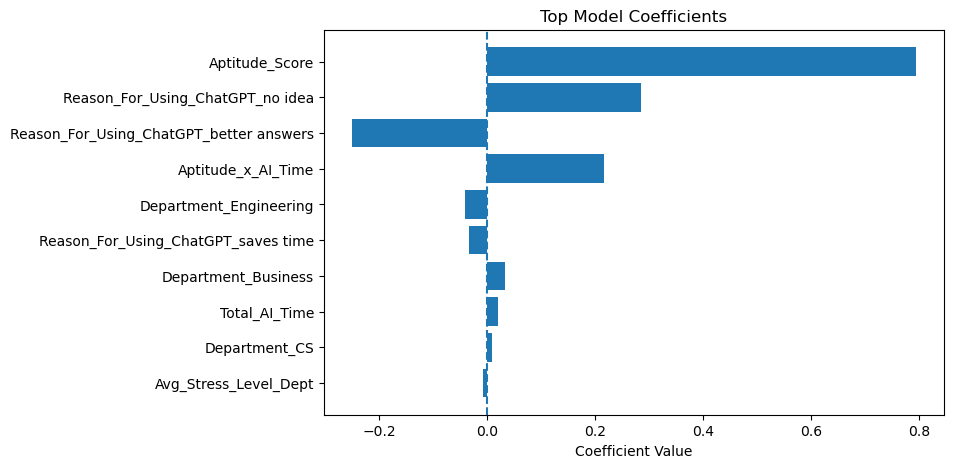

Top Predictive Features:
                                   Feature  Coefficient  abs_coef
1                           Aptitude_Score     0.793574  0.793574
8         Reason_For_Using_ChatGPT_no idea     0.284869  0.284869
7  Reason_For_Using_ChatGPT_better answers    -0.251032  0.251032
3                       Aptitude_x_AI_Time     0.215306  0.215306
6                   Department_Engineering    -0.042009  0.042009
9      Reason_For_Using_ChatGPT_saves time    -0.033836  0.033836
4                      Department_Business     0.032911  0.032911
0                            Total_AI_Time     0.019470  0.019470
5                            Department_CS     0.009098  0.009098
2                    Avg_Stress_Level_Dept    -0.008746  0.008746


In [199]:
import matplotlib.pyplot as plt
pre = best_model.named_steps["preprocess"]
model = best_model.named_steps["model"]

feature_names = []

# numeric features
feature_names.extend(numeric_features)

# categorical features
if categorical_features:
    ohe = pre.named_transformers_["cat"].named_steps["onehot"]
    feature_names.extend(
        ohe.get_feature_names_out(categorical_features)
    )

coefs = best_model.named_steps["model"].coef_

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs
})
coef_df["abs_coef"] = coef_df["Coefficient"].abs()

top_coef = coef_df.sort_values("abs_coef", ascending=False).head(15)

plt.figure(figsize=(8, 5))
plt.barh(top_coef["Feature"], top_coef["Coefficient"])
plt.axvline(0, linestyle="--")
plt.gca().invert_yaxis()
plt.xlabel("Coefficient Value")
plt.title("Top Model Coefficients")
plt.show()

print("Top Predictive Features:")
print(coef_df.sort_values("abs_coef", ascending=False))

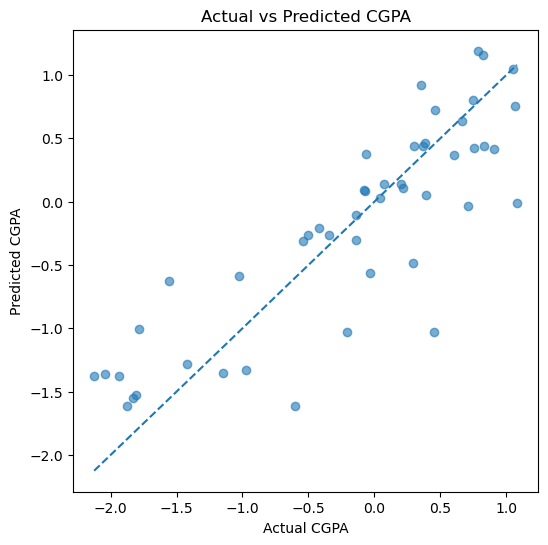

In [200]:
y_pred = best_model.predict(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("Actual CGPA")
plt.ylabel("Predicted CGPA")
plt.title("Actual vs Predicted CGPA")
plt.show()


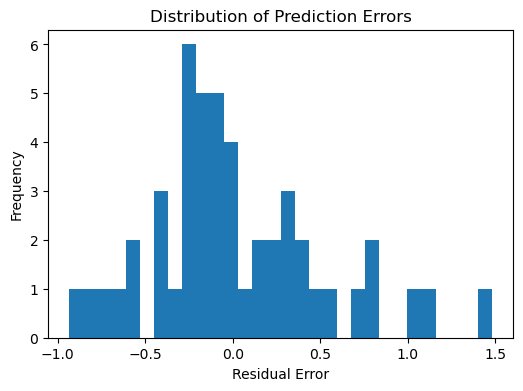

In [201]:
residuals = y_test - y_pred

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30)
plt.xlabel("Residual Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()